# Project Report 

#### Project Description 

- The project is about text sentiment classification on Tweet about Coronavirus during 3.13-3.16 this year.

- This part will do the prepocessing and clean of the raw data


### Part 1: Data Collection

#### Dataset source

- The dataset is collected by Aman Miglani posted on Kaggle. And the url is https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

- There are about 45000 Tweets from different users around the world and with 5 labels: extremly positive, positive, neutral, negative and extremely negative.

The very first step is always loading data while do some basic cleaning.

In [1]:
import re

def clean(string):
    string = re.sub(r'[^\x00-\x7F]+','', string).lower()
    string = re.sub(r'(\n|\t|\r)+','', string)
    return string

In [2]:
import pandas as pd
import csv
import nltk

def load_data_direct(filename, tweet_idx, sentiment_idx, is_index_col = False):
    # print('Begin loading data')
    
    very_pos, pos, neutral, neg, very_neg = '','','','',''
    if is_index_col:
        data = pd.read_csv(filename, index_col=0, encoding="ISO-8859-1", dtype=object)
    else:
        data = pd.read_csv(filename, encoding="ISO-8859-1", dtype=object)
    print("The input shape is :", data.shape)
    for r in range(data.shape[0]):
        if data.iloc[r, sentiment_idx] == 'Extremely Positive':
            very_pos += data.iloc[r, tweet_idx]
        elif data.iloc[r, sentiment_idx] == 'Positive':
            pos += data.iloc[r, tweet_idx]
        elif data.iloc[r, sentiment_idx] == 'Neutral':
            neutral += data.iloc[r, tweet_idx]
        elif data.iloc[r, sentiment_idx] == 'Negative':
            neg += data.iloc[r, tweet_idx]
        elif data.iloc[r, sentiment_idx] == 'Extremely Negative':
            very_neg += data.iloc[r, tweet_idx]
        else:
            print('Error Label, please check data')

    vp = nltk.sent_tokenize(clean(very_pos))
    ps = nltk.sent_tokenize(clean(pos))
    nl = nltk.sent_tokenize(clean(neutral))
    na = nltk.sent_tokenize(clean(neg))
    vn = nltk.sent_tokenize(clean(very_neg))

    return vp, ps, nl, na, vn

# load and separate data from csv
very_pos, pos, neutral, neg, very_neg = load_data_direct(
        './twitter_sentiment/Corona_NLP_train.csv', 3, 4, True)
sentences_size = len(very_pos)+len(pos)+len(neutral)+len(neg)+len(very_neg)
print(f"The total number of sentences is {sentences_size}")
print('Bag of words length (very_pos to very_neg): ', len(very_pos), ',', len(pos), ',',
          len(neutral), ',', len(neg), ',', len(very_neg))

The input shape is : (41157, 5)
The total number of sentences is 45151
Bag of words length (very_pos to very_neg):  8856 , 12439 , 6639 , 10528 , 6689


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np


def get_bag_of_words(ngram_range):
    print('Bag of words representation for ngrams range: ',ngram_range)
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(very_pos + pos + neutral + neg + very_neg)
    X = X.toarray()
    y = np.asarray([1 for i in range(0, len(very_pos))] + [2 for i in range(0, len(pos))] + [3 for i in range(0, len(neutral))] + [
            4 for i in range(0, len(neg))] + [5 for i in range(0, len(very_neg))])
    return X, y

print('--------------------------------------------------------------------------------')  
X_1, y_1 = get_bag_of_words((1,1))
print('Yields a array, X of size:', np.size(X_1, 0), 'sentences x', np.size(X_1, 1), 'tokens')

print('--------------------------------------------------------------------------------')
X_2, y_2 = get_bag_of_words((1,2))
print('Yields a array, X of size:', np.size(X_2, 0), 'sentences x', np.size(X_2, 1), 'tokens')


--------------------------------------------------------------------------------
Bag of words representation for ngrams range:  (1, 1)
Yields a array, X of size: 45151 sentences x 93373 tokens
--------------------------------------------------------------------------------
Bag of words representation for ngrams range:  (1, 2)
Yields a array, X of size: 45151 sentences x 582150 tokens


#### Analysis

- From the above bag of unigram words, we can see there are 93373 tokens for unigrams while 582150 tokens for bigram. So it will take more time to build a language model on bigrams.

#### Split csv into batches and save in json format

One important thing is that we need to merge multiple lines for one single tweet, so you can see that the final index is $41158$ but not $44955$.

In [4]:
from twitter_sentiment import LOAD, utils
import importlib
importlib.reload(utils)
importlib.reload(LOAD)


LOAD.compress_csv('twitter_sentiment/Corona_NLP_train.csv', 'twitter_sentiment/compress_train.csv')

utils.csvToJsonl(source_file      = 'twitter_sentiment/compress_train.csv', 
                 destination_file = 'twitter_sentiment/re_reviews.jsonl', 
                 batch_size       = 10000, 
                 verbose          = True)

/Users/liuchang/Downloads/nlp2020/liucha39/Project/Part4/twitter_sentiment/LOAD.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compress_data['OriginalTweet'] = compress_data['OriginalTweet'].str.replace('\s+',' ')
/Users/liuchang/Downloads/nlp2020/liucha39/Project/Part4/twitter_sentiment/LOAD.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compress_data['Sentiment'] = compress_data['Sentiment'].str.replace('\s+',' ')


The shape of dataframe after compress is: (41157, 2)
Saving compress data
Processed Batch 0 :  10001 / 41158 Lines
Processed Batch 1 :  20001 / 41158 Lines
Processed Batch 2 :  30001 / 41158 Lines
Processed Batch 3 :  40001 / 41158 Lines
Processed Batch 4 :  41158 / 41158 Lines


#### split train, valid and test set

In [5]:
importlib.reload(utils)
utils.splitFile( file       = 'twitter_sentiment/re_reviews.jsonl',
                 splits     = {'train'     :{'percentage':60},
                               'validation':{'percentage':20},
                               'test'      :{'percentage':20}},
                batch_size  = 10000,
                random_seed = 99,
                verbose     = True
               )

Initializing:  twitter_sentiment/train_re_reviews.jsonl
Initializing:  twitter_sentiment/validation_re_reviews.jsonl
Initializing:  twitter_sentiment/test_re_reviews.jsonl
Processed Batch 1 :  10000 / 41157 Lines
Processed Batch 2 :  20000 / 41157 Lines
Processed Batch 3 :  30000 / 41157 Lines
Processed Batch 4 :  40000 / 41157 Lines
Processed Batch 5 :  41157 / 41157 Lines


Now, let's reload the 5 classes of data after compresssion of the original table.

In [6]:
# load and separate data from csv
very_pos, pos, neutral, neg, very_neg = load_data_direct(
        'twitter_sentiment/compress_train.csv', 0, 1)

sentences_size = len(very_pos)+len(pos)+len(neutral)+len(neg)+len(very_neg)
print(f"The total number of sentences is {sentences_size}")

print('Bag of words length (very_pos to very_neg): ', len(very_pos), ',', len(pos), ',',
          len(neutral), ',', len(neg), ',', len(very_neg))

The input shape is : (41157, 2)
The total number of sentences is 52088
Bag of words length (very_pos to very_neg):  10208 , 14343 , 7728 , 12083 , 7726


#### Word2Vec Embedding

In [7]:
import gensim
from gensim.models import word2vec

def sentences2words(sentences):
    se = []
    for i, sentence in enumerate(sentences):
        se.append(nltk.word_tokenize(sentence))
    return se

vp = sentences2words(very_pos)
ps = sentences2words(pos)
nl = sentences2words(neutral)
na = sentences2words(neg)
vn = sentences2words(very_neg)

all_text_words = vp+ps+nl+na+vn

all_text_sentences = very_pos + pos + neutral + neg + very_neg
print("the sentences numbers are: ", len(all_text_sentences))


model = word2vec.Word2Vec(all_text_words, 
                          sg             = 1,     # Defines the training algorithm. By default (sg=0), CBOW is used. Otherwise (sg=1), skip-gram is employed.
                          min_count      = 1,     # min_count says to ignore all words with total frequency lower than this.
                          size           = 50,     # number of features
                          window         = 2,     # window is the maximum distance between the current and predicted word within a sentence.
                          sorted_vocab   = 1,     # if 1 (default), sort the vocabulary by descending frequency before assigning word indexes.
                          negative       = 5,     # if > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). # Default is 5. If set to 0, no negative samping is used.
                          max_vocab_size = None   # limit RAM during vocabulary building; if there are more unique words than this, then prune the infrequent ones. # Every 10 million word types need about 1GB of RAM. Set to None for no limit (default).
                         )

Vocab   = np.array(model.wv.index2word)
Vectors      = np.array(model.wv.vectors.tolist())

print('The vocabulary of the corpus is: ', np.shape(Vocab))
print('The Word2Vec vectors shape is: ', np.shape(Vectors))

the sentences numbers are:  52088
The vocabulary of the corpus is:  (97538,)
The Word2Vec vectors shape is:  (97538, 50)


### Part 2: Data Preprocessing

#### PCA Feature Reduction

In [8]:
from sklearn.decomposition import PCA

def PCA_Reduction(X, n):
    pca = PCA(n_components=n)
    X_p = pca.fit_transform(X)
    return X_p

In [9]:
# Calculate the Labels

print('The text length is:', len(all_text_words))

label = np.asarray([1 for i in range(0, len(vp))] + [2 for i in range(0, len(ps))] + [3 for i in range(0, len(nl))] + [
            4 for i in range(0, len(na))] + [5 for i in range(0, len(vn))])

print('The label length is:', len(label))

The text length is: 52088
The label length is: 52088


#### Model Experiment

In [10]:
from sklearn.naive_bayes     import MultinomialNB
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics         import confusion_matrix

X, y = get_bag_of_words((1,1))

vocab_size = X.shape[1]
print(X)
print(X.shape)
print(y.shape)
print(f"The vacabulary length is {vocab_size}")


Bag of words representation for ngrams range:  (1, 1)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(52088, 90753)
(52088,)
The vacabulary length is 90753


#### TFIDF/Normalization

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer

def TFIDF_transform(data):
    tfidf_transformer = TfidfTransformer()
    data_features_tfidf = tfidf_transformer.fit_transform(data)
    data_mat = data_features_tfidf.toarray()
    return data_mat


Since the memory limitation, we only use half of the total data to do the bag of words in the notebook and the result using the whole dataset will be included in another file

In [12]:
import numpy as np
random_list = np.random.choice(X.shape[0], 2000, replace = False)
X = X[random_list, :]
y = y[random_list]
print('The shape after random choice:', X.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, stratify = y, random_state = 123)

X_train_TFIDF = TFIDF_transform(X_train)
X_test_TFIDF  = TFIDF_transform(X_test)

X_train = PCA_Reduction(X_train, 50)
X_test  = PCA_Reduction(X_test,  50)

X_train_TFIDF = PCA_Reduction(X_train_TFIDF, 50)
X_test_TFIDF = PCA_Reduction(X_test_TFIDF,50)

print(X.shape)
print(len(X_train))
print(len(X_test))

The shape after random choice: (2000, 90753)
(2000, 90753)
1600
400


Besides the PCA feature reduction, we can also use the TFIDF to modify the word vectors because the TFIDF can measure the relative importance of a word within a document, in the context of multiple documents.

#### Define the confusion matrix plot funcion

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_heatmap(cm): 
    plt.figure(figsize = (6,4))
    sns.heatmap(cm, annot=True, cmap='Blues')

### Part 3: Models Experiments

#### Naive Bayes

The confusion matrix is:
 [[11 11  8 14  7]
 [ 6 18  6 11  3]
 [50 64 35 60 40]
 [ 3  6  5  6  7]
 [ 5 11  3  4  6]]
The accuracy is:  19.0 %
The precision is: 25.8 %


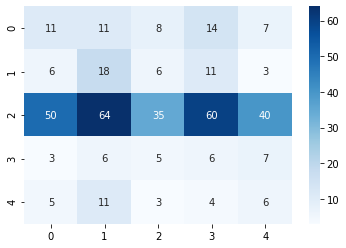

In [14]:
from sklearn.naive_bayes     import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics         import confusion_matrix, precision_score

# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.8,random_state=123)

naive      = GaussianNB()

classifier = naive.fit(X_train,y_train)

predict    = classifier.predict(X_test)
cm         = confusion_matrix(predict,y_test)
print('The confusion matrix is:\n', cm)

print('The accuracy is: ', 100.0*np.sum(np.diag(cm))/np.sum(cm), '%')
precision = precision_score(y_test, predict, average='weighted')
print("The precision is:", np.round(100.0*precision,1), '%')
plot_heatmap(cm)

Now, we get the very first model of the sentiment dataset using naive bayes. Notice the diagnol of the confusion matrix present the true positives of our prediction.

The confusion matrix is:
 [[23 25 14 22 14]
 [ 5  8  2  8  6]
 [ 7 22 17 12  5]
 [ 6 19 10 11  4]
 [34 36 14 42 34]]
The accuracy is:  23.25 %
The precision is: 24.4 %


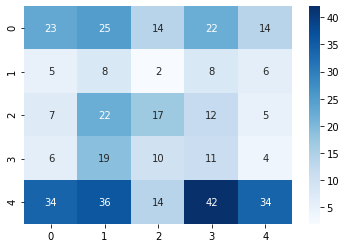

In [15]:
naive      = GaussianNB()

classifier = naive.fit(X_train_TFIDF,y_train)

predict    = classifier.predict(X_test_TFIDF)
cm         = confusion_matrix(predict,y_test)
print('The confusion matrix is:\n', cm)

print('The accuracy is: ', 100.0*np.sum(np.diag(cm))/np.sum(cm), '%')
precision = precision_score(y_test, predict, average='weighted')
print("The precision is:", np.round(100.0*precision,1), '%')
plot_heatmap(cm)

We can retrain the model by TFIDF before the PCA feature reduction. you can see the performance of the model slightly increases.

#### Logistic Regression

Another basic model is the logistic regression which is simple but robust.

The confusion matrix is:
 [[11 13  6 11  8]
 [37 57 25 49 24]
 [ 6  9 13  5  2]
 [20 28  8 23 22]
 [ 1  3  5  7  7]]
The accuracy is:  27.75 %
The precision is: 27.9 %


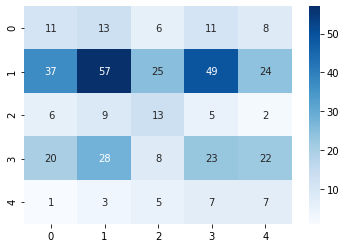

In [16]:
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression()

classifier = LogReg.fit(X_train_TFIDF,y_train)

predict    = classifier.predict(X_test_TFIDF)
cm         = confusion_matrix(predict,y_test)
print('The confusion matrix is:\n', cm)

print('The accuracy is: ', 100.0*np.sum(np.diag(cm))/np.sum(cm), '%')
precision = precision_score(y_test, predict, average='weighted')
print("The precision is:", np.round(100.0*precision,1), '%')
plot_heatmap(cm)

We can see that the final accucary improves slightly. However, these three basic models' performances are quite bad which means they underfit the sentiment dataset. In other words, these models are too simple and can't fit the training set. If we want to get higher accuracy on the test set, some other models with more complicated structures can help.

#### LSTM recurrent neutral network

First, let us transform the data into pytorch form in order to train and test

In [17]:
importlib.reload(utils)
LOAD.random_choice_csv('twitter_sentiment/compress_train.csv', 'twitter_sentiment/simple.csv', 2000)

utils.csvToJsonl(source_file      = 'twitter_sentiment/simple.csv', 
                 destination_file = 'twitter_sentiment/simple.jsonl', 
                 batch_size       = 10000, 
                 verbose          = True)

utils.get_vocab_batches('twitter_sentiment/simple.jsonl', 'twitter_sentiment/vocabulary_simple.jsonl', 2000)
vocabulary = utils.prepareVocabulary(vocab_json = 'twitter_sentiment/vocabulary_simple.jsonl', remove_less_than = 1)

utils.splitFile( file       = 'twitter_sentiment/simple.jsonl',
                 splits     = {'train'     :{'percentage':80},
                               'test'      :{'percentage':20}},
                batch_size  = 10000,
                random_seed = 99,
                verbose     = True
               )

                                          OriginalTweet           Sentiment
0     Blue Dart Express reduces retail tariff prices...            Negative
1     #G20 need to co-operate and assure global food...            Positive
2     There have been chaotic scenes at some superma...  Extremely Negative
3     Asian businesses Pakistani Indian amp Banglade...            Negative
4     Pre this was considered a gag gift Post this i...  Extremely Positive
...                                                 ...                 ...
1995  Was at the grocery store. No fruits and vegeta...  Extremely Negative
1996  GMD @MKKyari: "We decided that fuel subsidy/un...  Extremely Positive
1997  @LidlGB It's all well and good having a websit...            Negative
1998  People know to look for credit card skimmers o...            Negative
1999  Dear God, Please stop this CoronaVirus Outbrea...            Positive

[2000 rows x 2 columns]
Processed Batch 0 :  2001 / 2001 Lines
The size of vocabulary i

Then, we need to update the vocabulary using the pre-trained gloves embeddings to convert sentences to word vectors

In [18]:
importlib.reload(utils)
glove_embeddings = utils.loadEmbeddings(path          = 'twitter_sentiment/glove.6B.50d.txt', 
                                        vocabulary    = vocabulary, 
                                        embedding_dim = 50)

Next, we set up the LSTM hyper parameters.

In [19]:
from LR import LSTM, AllData, train, test
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch
from torch.autograd import Variable

num_hidden_nodes   = 32
num_output_nodes   = 1
num_layers         = 2
bidirectional      = False
dropout            = 0.2
size_of_vocab      = len(vocabulary)
print("vocab length is ", size_of_vocab)
embeddings         = glove_embeddings
embedding_dim      = glove_embeddings.size()[1]

model = LSTM(size_of_vocab, embedding_dim,embeddings,num_hidden_nodes,
                   num_output_nodes, num_layers, bidirectional = bidirectional, dropout = dropout)
optimizer       = optim.Adam(model.parameters())
criterion       = nn.BCELoss()
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model     = model.to(device)
criterion = criterion.to(device)

print(model)
importlib.reload(utils)
print(f'The model has {utils.count_parameters(model):,} trainable parameters')

vocab length is  8788
LSTM(
  (embedding): Embedding(8788, 50)
  (lstm): LSTM(50, 32, num_layers=2, dropout=0.2)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 458,633 trainable parameters


0  train loss: 2.055147911408435
0  test loss: 2.005940065678827
10  train loss: 1.7725300999068518
10  test loss: 1.7336168309716349
20  train loss: 1.2308101864082108
20  test loss: 1.2948009265045044
30  train loss: 0.514065454941164
30  test loss: 0.607161063001447
40  train loss: 0.5622501251916715
40  test loss: 0.46341954923687007
50  train loss: 0.15602314885593727
50  test loss: 0.19792623117593983
60  train loss: 0.567858618685383
60  test loss: 0.27242536258730404
70  train loss: 0.2665889094673815
70  test loss: 0.19303299945180102
80  train loss: 0.05501967291267986
80  test loss: 0.221737825639953
90  train loss: 0.0775566438451047
90  test loss: 0.16694493087788714
100  train loss: 0.025718820598208403
100  test loss: 0.018597513636414802
110  train loss: 0.06188528504902747
110  test loss: 0.0399142779641323
120  train loss: 0.010989173616893874
120  test loss: 0.04046421080176146
130  train loss: 0.05369389983042412
130  test loss: 0.017192984099874666
140  train loss:

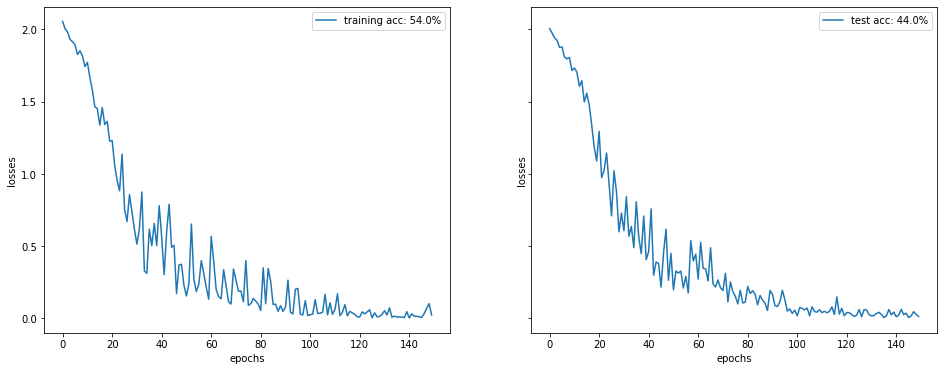

In [20]:
from LR import LSTM, AllData, train, test
import math

Train_loss, Test_loss = [],[]
train_acc, test_acc = 0, 0
for ep in range(150):
    train_loss, train_acc = train(ep, model, optimizer, criterion, bidirectional, vocabulary)
    test_loss, test_acc  = test(ep, model, optimizer, criterion, bidirectional, vocabulary)
    
    Train_loss.append(math.exp(train_loss))
    Test_loss.append(math.exp(test_loss))
print('The training loss is:', Train_loss[-1])
print('The test loss is:', Test_loss[-1])


import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, sharey=True, figsize=(16,6))
axs[0].plot(range(len(Train_loss)), Train_loss, label = 'training acc: '+str(train_acc)+'%')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('losses')
axs[0].legend()

axs[1].plot(range(len(Test_loss)), Test_loss, label = 'test acc: '+str(test_acc)+'%')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('losses')
axs[1].legend()

plt.show()

From the training and validation plots, we can see that both datasets converges after about 100 epochs. And the accuracy on the test set reaches about 45\% which is much better than the Naive Bayes and Logstic regression models that we used.

#### LSTM bidirectional recurrent neutral network

The classical LSTM network acts like reading through texts, but we can use a bidirectional LSTM to train our model and it will utilize the words order information again to improve the result.

In [21]:
from LR import LSTM, AllData, train, test
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch
from torch.autograd import Variable

num_hidden_nodes   = 32
num_output_nodes   = 1
num_layers         = 2
bidirectional      = True
dropout            = 0.1
size_of_vocab      = len(vocabulary)
print("vocab length is ", size_of_vocab)
embeddings         = glove_embeddings
embedding_dim      = glove_embeddings.size()[1]

model = LSTM(size_of_vocab, embedding_dim,embeddings,num_hidden_nodes,
                   num_output_nodes, num_layers, bidirectional = bidirectional, dropout = dropout)
optimizer       = optim.Adam(model.parameters())
criterion       = nn.BCEWithLogitsLoss()
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model     = model.to(device)
criterion = criterion.to(device)

print(model)
importlib.reload(utils)
print(f'The model has {utils.count_parameters(model):,} trainable parameters')

vocab length is  8788
LSTM(
  (embedding): Embedding(8788, 50)
  (lstm): LSTM(50, 32, num_layers=2, dropout=0.1, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 486,057 trainable parameters


0  train loss: 1.4835973312665434
0  test loss: 1.3194037062326307
10  train loss: 1.4864427486533862
10  test loss: 1.2158844431325462
20  train loss: 1.3167201261671642
20  test loss: 1.2688452680925368
30  train loss: 0.9883847702009166
30  test loss: 0.9879616935583935
40  train loss: 0.7994865782721993
40  test loss: 1.2031506540262682
50  train loss: 1.022066240740124
50  test loss: 0.9062234978800888
60  train loss: 0.8850838058738283
60  test loss: 1.2212110182867826
70  train loss: 0.8533932185501875
70  test loss: 1.0922099217687002
80  train loss: 0.7632583266978454
80  test loss: 1.052273212653045
90  train loss: 0.8561668976230683
90  test loss: 0.9986474275972371
100  train loss: 0.9135122530491495
100  test loss: 0.9796679861947459
110  train loss: 1.0236587382235953
110  test loss: 1.016280886658337
120  train loss: 0.8657029544022437
120  test loss: 0.9362807354227309
130  train loss: 0.9800814065700604
130  test loss: 0.9477812224506862
140  train loss: 0.757841975806

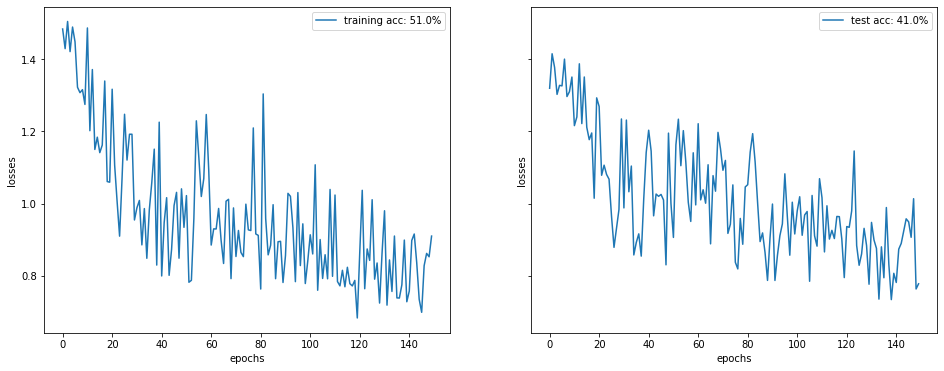

In [22]:
from LR import LSTM, AllData, train, test
import math

Train_loss, Test_loss = [],[]
train_acc, test_acc = 0, 0
for ep in range(150):
    train_loss, train_acc = train(ep, model, optimizer, criterion, bidirectional, vocabulary)
    test_loss, test_acc  = test(ep, model, optimizer, criterion, bidirectional, vocabulary)
    
    Train_loss.append(math.exp(train_loss))
    Test_loss.append(math.exp(test_loss))
print('The training loss is:', Train_loss[-1])
print('The test loss is:', Test_loss[-1])


import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, sharey=True, figsize=(16,6))
axs[0].plot(range(len(Train_loss)), Train_loss, label = 'training acc: '+str(train_acc)+'%')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('losses')
axs[0].legend()

axs[1].plot(range(len(Test_loss)), Test_loss, label = 'test acc: '+str(test_acc)+'%')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('losses')
axs[1].legend()

plt.show()

From the result of the bidirectional LSTM, we can see that the test accuracy improves from 42\% to 46\%, but the losses are higher than the single directional LSTM. One possible reason is that the bidirectional LSTM is more complicated which can better fit the dataset but will increase the losses.

#### Word Sentiment features

By now, we used the statistical models to train and test the dataset. However, we have not explored the prior knowledge of words or phrases. So let's insert the word sentiments as new features and feed them into the models.

In [23]:
sentiment = {}

with open('twitter_sentiment/sentiwordnet.txt', newline = '') as f:                                                                                          

    csvreader = csv.reader(f, delimiter='\t')
    
    for i, line in enumerate(csvreader):
        if i == 0:
            headers = line
        else:
            words = line[4]
            for word in words.split():
                sentiment[word] = {'PosScore': line[2], 'NegScore': line[3]}

In [24]:
print(sentiment['happy#1'])

{'PosScore': '0.875', 'NegScore': '0'}


We first include the pretrained sentiment words table and print out the sentiment values (positive and negative) for the vocabulary for example, 'happy'.

In [25]:
def sentiment_feature_L1(all_text):
    senti_sentences = []

    for sent in all_text:
        words = nltk.word_tokenize(sent)
        s = 0
        for w in words:
            word = w + '#1'
            if word in sentiment.keys():
                s += float(sentiment[word]['PosScore']) - float(sentiment[word]['NegScore'])
        senti_sentences.append(s)
    senti_sentences = np.array(senti_sentences)
    return senti_sentences

def sentiment_feature_L2(all_text):
    senti_sentences = []

    for sent in all_text:
        words = nltk.word_tokenize(sent)
        s = 0
        for w in words:
            word = w + '#1'
            if word in sentiment.keys():
                s += float(sentiment[word]['PosScore'])**2 - float(sentiment[word]['NegScore'])**2
        senti_sentences.append(s)
    senti_sentences = np.array(senti_sentences)
    return senti_sentences

We define 2 different sentiment calculations for each sentence: one is summing up all sentiment values of the wordsin the sentence; the other one is summing up the L2 values instead. Let's view some samples of these 2 sentiment features.

In [26]:
all_text_sentences = very_pos + pos + neutral + neg + very_neg
l1_sentiment = sentiment_feature_L1(all_text_sentences)
l2_sentiment = sentiment_feature_L2(all_text_sentences)

In [27]:
print('---------------------------------')
print("The sample l1 sentiments for sentences are\n",l1_sentiment[:20])
print('---------------------------------')
print("The sample l2 sentiments for sentences are\n",l2_sentiment[:20])

---------------------------------
The sample l1 sentiments for sentences are
 [ 0.5    0.25   0.75   1.375 -0.5    0.75   0.875  0.    -0.875 -0.125
  0.    -0.875 -0.375  0.     0.875  1.375  2.625  0.375  0.625  0.875]
---------------------------------
The sample l2 sentiments for sentences are
 [ 0.25    0.0625  0.5625  0.8281 -0.5     0.375   0.4844  0.     -0.5156
  0.1094  0.     -0.5156 -0.0781  0.      0.3594  0.9531  1.5156  0.1406
  0.3906  0.4531]


Now, we insert the new features we get into the bag of words generated previously.

In [28]:
# select 2000 samples corresponding to the bag of words above
l1_sent = l1_sentiment[random_list]
l2_sent = l2_sentiment[random_list]

def merge(X, y, sentiment):
    X_new = np.concatenate((X, sentiment[:, None]),axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, train_size = 0.8, stratify = y, random_state = 123)

    X_train_TFIDF = TFIDF_transform(X_train[:,:-1])
    X_train_sent = X_train[:,-1]
    X_test_TFIDF  = TFIDF_transform(X_test[:,:-1])
    X_test_sent = X_test[:,-1]

    X_train = PCA_Reduction(X_train_TFIDF, 50)
    X_test = PCA_Reduction(X_test_TFIDF,50)
    
    X_train = np.concatenate((X_train, X_train_sent[:, None]),axis=1)
    X_test = np.concatenate((X_test, X_test_sent[:, None]),axis=1)
    
    return X_train, X_test, y_train, y_test


#### L1 Sentiment features

In [29]:
X_train, X_test, y_train, y_test = merge(X, y, l1_sent)

In [30]:
print("The shape of training and test samples are")
print(X_train.shape,',', X_test.shape)

The shape of training and test samples are
(1600, 51) , (400, 51)


The l1 sentiment Naive Bayes result
---------------------------------
The confusion matrix is:
 [[29 15  9 18 14]
 [ 0 10  3  8  4]
 [ 6 22 17 12  5]
 [10 17  8 11 10]
 [30 46 20 46 30]]
The accuracy is:  24.25 %
The precision is: 28.7 %


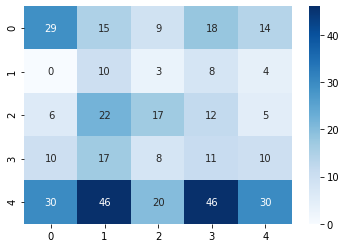

In [31]:
naive      = GaussianNB()

classifier = naive.fit(X_train,y_train)

predict_bayes    = classifier.predict(X_test)
cm         = confusion_matrix(predict_bayes,y_test)
print("The l1 sentiment Naive Bayes result")
print("---------------------------------")
print('The confusion matrix is:\n', cm)

print('The accuracy is: ', 100.0*np.sum(np.diag(cm))/np.sum(cm), '%')
precision = precision_score(y_test, predict_bayes, average='weighted')
print("The precision is:", np.round(100.0*precision,1), '%')
plot_heatmap(cm)

The confusion matrix is:
 [[16  9  5  6  6]
 [37 57 25 50 26]
 [ 3  7 13  4  1]
 [17 31 10 26 19]
 [ 2  6  4  9 11]]
The accuracy is:  30.75 %
The precision is: 33.2 %


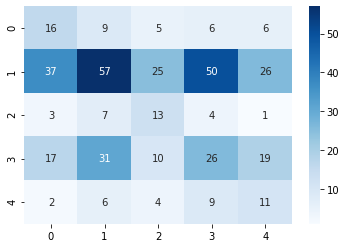

In [32]:
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression()

classifier = LogReg.fit(X_train,y_train)

predict_log    = classifier.predict(X_test)
cm         = confusion_matrix(predict_log,y_test)
print('The confusion matrix is:\n', cm)

print('The accuracy is: ', 100.0*np.sum(np.diag(cm))/np.sum(cm), '%')
precision = precision_score(y_test, predict_log, average='weighted')
print("The precision is:", np.round(100.0*precision,1), '%')
plot_heatmap(cm)

You can see that the result of both Naive Bayes and Logistic Regression improves about 5\% on test set accuracy.

#### L2 Sentiment features

Now we try our new bag of words on L2 sentiment features.

In [33]:
X_train, X_test, y_train, y_test = merge(X, y, l2_sent)

The l1 sentiment Naive Bayes result
---------------------------------
The confusion matrix is:
 [[25 16  6 19 14]
 [ 7 16  5 11  3]
 [ 7 18 19 11  5]
 [ 6 25  6  8  5]
 [30 35 21 46 36]]
The accuracy is:  26.0 %
The precision is: 28.0 %


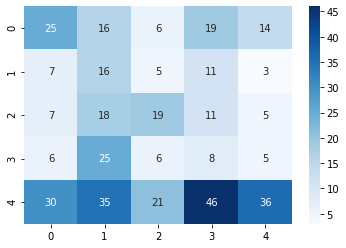

In [34]:
naive      = GaussianNB()

classifier = naive.fit(X_train,y_train)

predict    = classifier.predict(X_test)
cm         = confusion_matrix(predict,y_test)
print("The l1 sentiment Naive Bayes result")
print("---------------------------------")
print('The confusion matrix is:\n', cm)

print('The accuracy is: ', 100.0*np.sum(np.diag(cm))/np.sum(cm), '%')
precision = precision_score(y_test, predict, average='weighted')
print("The precision is:", np.round(100.0*precision,1), '%')
plot_heatmap(cm)

The confusion matrix is:
 [[17 12  1 10  7]
 [35 66 27 41 27]
 [ 2  5 15  5  2]
 [19 25  8 27 19]
 [ 2  2  6 12  8]]
The accuracy is:  33.25 %
The precision is: 34.2 %


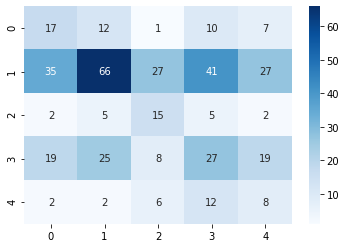

In [35]:
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression()

classifier = LogReg.fit(X_train,y_train)

predict    = classifier.predict(X_test)
cm         = confusion_matrix(predict,y_test)
print('The confusion matrix is:\n', cm)

print('The accuracy is: ', 100.0*np.sum(np.diag(cm))/np.sum(cm), '%')
precision = precision_score(y_test, predict, average='weighted')
print("The precision is:", np.round(100.0*precision,1), '%')
plot_heatmap(cm)

We can get similar result as L1 sentiment shown above which improves the accuracy on test set.

#### A brief sum-up 

<span style="text-decoration:underline">We can see that the Naive Bayes and Logistic regression improve with the semantical features, but the overall accuracy is still low. So we would like to try other classification techniques.</span>

In [36]:
X_train, X_test, y_train, y_test = merge(X, y, l1_sent)

#### SVM

The confusion matrix is:
 [[16  9  1 11  7]
 [43 76 39 50 24]
 [ 0  1  4  1  0]
 [13 23 10 30 24]
 [ 3  1  3  3  8]]
The accuracy is:  33.5 %
The precision is: 39.5 %


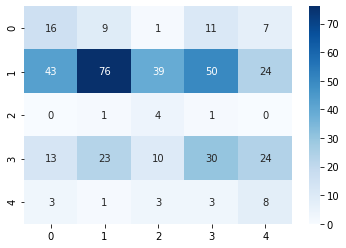

In [37]:
from sklearn import svm

SVM = svm.SVC(decision_function_shape='ovo')

classifier = SVM.fit(X_train,y_train)

predict_svm    = classifier.predict(X_test)
cm         = confusion_matrix(predict_svm,y_test)
print('The confusion matrix is:\n', cm)

print('The accuracy is: ', 100.0*np.sum(np.diag(cm))/np.sum(cm), '%')
precision = precision_score(y_test, predict_svm, average='weighted')
print("The precision is:", np.round(100.0*precision,1), '%')
plot_heatmap(cm)

#### K Nearest Neighbours

The confusion matrix is:
 [[30 34 15 24 12]
 [10 16  5  9  8]
 [ 6 11 13  3  5]
 [12 17 11 14  8]
 [17 32 13 45 30]]
The accuracy is:  25.75 %
The precision is: 27.7 %


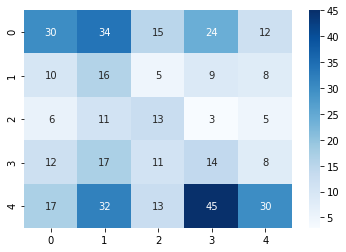

In [38]:
from sklearn.neighbors import NearestCentroid

KNN = NearestCentroid()

classifier = KNN.fit(X_train,y_train)

predict_knn    = classifier.predict(X_test)
cm         = confusion_matrix(predict_knn,y_test)
print('The confusion matrix is:\n', cm)

print('The accuracy is: ', 100.0*np.sum(np.diag(cm))/np.sum(cm), '%')
precision = precision_score(y_test, predict_knn, average='weighted')
print("The precision is:", np.round(100.0*precision,1), '%')
plot_heatmap(cm)

#### Decision Tree

The confusion matrix is:
 [[16 27 16 17 15]
 [11 25 11 23 17]
 [13  9  6 12  9]
 [22 29 14 22 11]
 [13 20 10 21 11]]
The accuracy is:  20.0 %
The precision is: 20.6 %


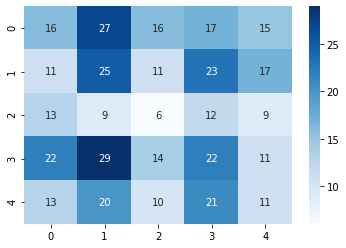

In [39]:
from sklearn import tree

DT = tree.DecisionTreeClassifier()

classifier = DT.fit(X_train,y_train)

predict_dt    = classifier.predict(X_test)
cm         = confusion_matrix(predict_dt,y_test)
print('The confusion matrix is:\n', cm)

print('The accuracy is: ', 100.0*np.sum(np.diag(cm))/np.sum(cm), '%')
precision = precision_score(y_test, predict_dt, average='weighted')
print("The precision is:", np.round(100.0*precision,1), '%')
plot_heatmap(cm)

### Part 4: Ensemble Models

There are multiple ways to combine multiple models together.

1. Random Forest combines different decision tree, in which every tree has the equal weights to vote for the final prediction of the class.

2. Bagging: Directly combine all classifiers together and do the vote.

3. Adaboost: Adujst weights for different classifiers, increasing weights for those data incorrectly classified and doing the opposite for correctly classified data step by step.

#### Random Forest

The confusion matrix is:
 [[ 9  9 10 15 12]
 [36 59 34 60 26]
 [ 4  5  0  0  1]
 [21 28 11 14 18]
 [ 5  9  2  6  6]]
The accuracy is:  22.0 %
The precision is: 17.6 %


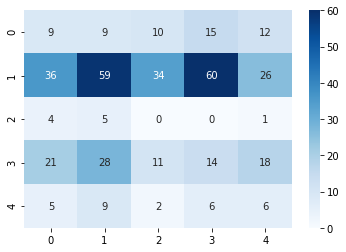

In [40]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=60)

classifier = RF.fit(X_train,y_train)

predict    = classifier.predict(X_test)
cm         = confusion_matrix(predict,y_test)
print('The confusion matrix is:\n', cm)

print('The accuracy is: ', 100.0*np.sum(np.diag(cm))/np.sum(cm), '%')
precision = precision_score(y_test, predict, average='weighted')
print("The precision is:", np.round(100.0*precision,1), '%')
plot_heatmap(cm)

#### Bagging

Combine SVM, KNN and DT classifiers together.

The confusion matrix is:
 [[19 22  8 13 10]
 [20 42 25 25 18]
 [ 6  4  7  3  5]
 [22 24  7 20 11]
 [ 8 18 10 34 19]]
The accuracy is:  26.75 %
The precision is: 26.8 %


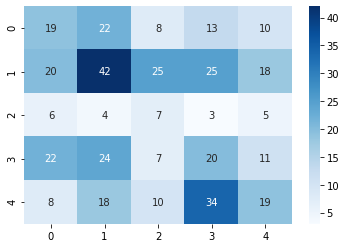

In [41]:
pred = []
for i in range(len(predict_knn)):
    vol = [predict_knn[i], predict_svm[i], predict_dt[i]]
    idx = np.random.choice(len(vol), 1)[0]
    pred.append(vol[idx])

cm         = confusion_matrix(pred, y_test)
print('The confusion matrix is:\n', cm)

print('The accuracy is: ', 100.0*np.sum(np.diag(cm))/np.sum(cm), '%')
precision = precision_score(y_test, pred, average='weighted')
print("The precision is:", np.round(100.0*precision,1), '%')
plot_heatmap(cm)

#### Adaboost

The confusion matrix is:
 [[12 11  2 15  4]
 [21 47 26 39 14]
 [17 19 11 16  7]
 [13 22 12 14 18]
 [12 11  6 11 20]]
The accuracy is:  26.0 %
The precision is: 25.6 %


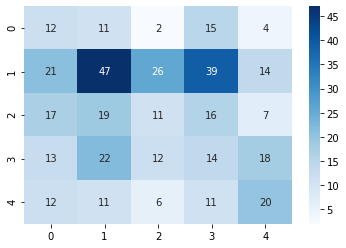

In [42]:
from sklearn.ensemble import AdaBoostClassifier

Ada = AdaBoostClassifier(n_estimators=30)

classifier = Ada.fit(X_train,y_train)

predict    = classifier.predict(X_test)
cm         = confusion_matrix(predict,y_test)
print('The confusion matrix is:\n', cm)

print('The accuracy is: ', 100.0*np.sum(np.diag(cm))/np.sum(cm), '%')
precision = precision_score(y_test, predict, average='weighted')
print("The precision is:", np.round(100.0*precision,1), '%')
plot_heatmap(cm)

#### Brief Summary
The ensemble methods are expected to perform better than most single models expect neutral network. However, we have not seen such improvement. On possible reason is that the words order is quite important bu the bag of words discard it. All ensemble methods share the disadvantages.

### Part 5: Conclusion

- By now, we test the classical unsupervised learning techniques like Naive Bayes or Logistic Regression, as well as the LSTM (single and bidirectional) models. Meanwhile, we build a hybrid model which combines the unsupervised learning techniques and the word sentiment knowledge.

- We can see the obvious improvement by give word sentiment features to the unsupervised models. But the LSTM models we experiment do better because it includes the words order information which is discarded by the bag of words.